# The NetSecure NIDS
The startup company NetSecure has been observing the recent hacks on the news. Because they are working on a new product, and they want to protect their intellectual property, they have decided to improve their network security.
	
To this end, they want to deploy a Network Intrusion Detection System (NIDS) that analyses all the traffic passing between their internal network and the internet. Unfortunately, all security solutions provided by security companies are too expensive for NetSecure. Therefore they approached you with the assignment of building a NIDS.

## Network setup
NetSecure is a small company with only 3 employees. All of whom have a single desktop machine which they use for their daily work. Furthermore, the company runs a server which provides various webservices to the internet. Figure 1 gives an overview of the network structure of NetSecure. It also shows where the NIDS will be placed.

<img src="images/network.png" width=600>
<div align="center">Figure 1. Overview of the network setup of company NetSecure, including the IP addresses of their machines.</div>

## Available data
In order to train the NIDS that you are creating you are given two datasets of network traffic, both captured at the router as given in Figure 1.
	
 1. A dataset of benign traffic.
 2. A dataset of unknown traffic.

It is up to you to train a machine learning algorithm with the benign traffic. Once you have trained the NIDS, you will test the unknown traffic to determine which parts should be classified as benign and which parts should be classified as malicious.
	
The network traffic that is captured is provided as a .csv file of individual TCP and UDP packets. Each packet has the following features:

 * *timestamp*, indicating at what time the packet was sent.
 * *protocol*, indicating whether the packet was sent over TCP or UDP.
 * *src*, the source IP address of the packet.
 * *sport*, the source port of the packet.
 * *dst*, the destination IP address of the packet.
 * *dport*, the destination port of the packet.
 * *packet size*, indicating the amount of bytes sent in the packet.

Furthermore, the dataset of benign traffic also contains labels of the applications that are generating the network traffic.
## Anthony Irokosu s2261065

## Assignment
In this assignment we will walk through all the steps necessary to create a proper NIDS for NetSecure. The first thing we need to do is load the assignment.



In [1]:
# Imports numpy and pandas libraries
import numpy  as np
import pandas as pd

# Imports assignment from backend
from ml4sec import Assignment

# Initialises assignment with given files.
# HINT: make sure you extract the benign.csv and unknown.csv files in data directory as assignment.ipynb
assignment = Assignment(
    file_benign  = 'data/benign.csv',
    file_unknown = 'data/unknown.csv',
)

## 1. Feature selection/extraction
The network packets in the transport layer (i.e. TCP and UDP packets) all belong to a network flow. Such a flow is given by the 5-tuple (*protocol*, *src*, *sport*, *dst*, *dport*). All of the packets within such a flow belong to the same application. We can leverage this knowledge to group packets together and extract statistical features from them as a group.

**Question 1.1.** We can compute some statistical features of each group. These features may give us an advantage in the detection phase of our NIDS. Which statistical features can be computed?

*(Hint 1: An example feature could be the maximum length of a packet in a flow.)*

*(Hint 2: The timestamp itself does not say much about the origin of a packet, however the frequency (i.e. time between packets) might give us some more information.)*

**NB:** in this question it is up to you to determine how many features you want to extract. Keep in mind that this will have influence on the performance of your NIDS so think carefully about the features you could extract.

In [ ]:
## I used the mean, the minimum , the maximum and the variance of the frequency of the timestamps and the packet sizes

**Question 1.2.** We now want to extract these new features for each flow. To this end, you will implement the function `extract()` which has access to the `protocol`, `src`, `sport`, `dst`, `dport` of a flow, as well as the `timestamps`, and `sizes` for each packet within the flow. Your assignment is to implement `extract` which should return a list of extracted features as described the in previous question. Note that this function is called for each flow. To test your method for X flows, please run the `assignment.test_extract(X)` as described below.

In [9]:
def extract(protocol, src, sport, dst, dport, timestamps, sizes):
    extracted_features = []
    #timestamp features
    interval_time = []
    #get the average interval time
    for i in range(len(timestamps) - 1):
        interval = abs(timestamps[i+1] - timestamps[i])
        interval_time.append(interval)
    #mean of intervals 
    extracted_features.append(np.mean(interval_time)) #add mean interval to feature set
    extracted_features.append(np.min(interval_time))  #add the minimum interval time
    extracted_features.append(np.max(interval_time))  #add the maximum interval time #add the median interval time
    extracted_features.append(np.var(interval_time))  #add the variance of the interval
    
    #size features
    
    extracted_features.append(sizes.mean()) #add mean of the size
    extracted_features.append(sizes.min()) #add the minimum of the size
    extracted_features.append(sizes.max()) #add the maximum value of size
    extracted_features.append(np.var(sizes)) #add the variance of the sizes
    
    
    
            
        
    return extracted_features
# Set extract method
assignment.extract = extract

You can use the code below to test your implementation of `extract()` with a given number of flows.

In [10]:
# Changes the number to test different numbers of flows
assignment.test_extract(0)

Now that we extracted the features, we represent them in a feature matrix. Each row in this matrix represents a flow and each column represents a feature. Run the code below to show the feature matrix for your feature extraction.

In [11]:
# Shows feature matrix
assignment.show_matrix()

,0,1,2,3,4,5,6,7
0,2.017519,1.815252,2.183502,0.006899,777.489796,664.0,867.0,2106.658059
1,2.022434,1.815907,2.247271,0.011659,790.458333,702.0,906.0,1947.331597
2,0.982999,0.795367,1.260010,0.009894,617.465116,483.0,799.0,6237.365062
3,2.008661,1.786514,2.232194,0.012310,1158.833333,1129.0,1187.0,122.615079
4,2.013165,1.759076,2.276765,0.011227,1164.767442,1134.0,1194.0,177.992428
...,...,...,...,...,...,...,...,...
12584,1.004994,0.827151,1.196490,0.008670,996.621622,838.0,1151.0,4522.397370
12585,1.014599,0.814481,1.211509,0.008589,993.756757,801.0,1156.0,6719.805698
12586,0.997396,0.803255,1.258667,0.011758,998.200000,891.0,1199.0,4165.460000
12587,1.018561,0.814956,1.231149,0.010972,996.743590,831.0,1123.0,4833.575279


## 2. Data Preprocessing
The data that we have stored is composed of different features. All these features are stored within a range of values. For example, the length of a packet is limited by the Maximum Transmission Unit (MTU), which by default is 1500 bytes giving this feature a range of [0, 1500]. Conversely, we may observe from the data that the average time between packets is in the range [0, 10] seconds. When a machine learning algorithm tries to compare two datapoints, it will put a much greater weight to the feature with range [0, 1500] than the feature with range [0, 10] because the absolute differences are much larger. Instead, we would like to compare the relative distances for each feature. To this end, we apply a technique called `scaling`.

There are many different scaling techniques, but for the purpose of creating a NIDS, we will use min-max scaling. This scaling technique scales the original values in such a way that the minimum value for each feature is mapped to 0, and the maximum value for each feature is mapped to 1. The relative distance between each values is preserved. The formula for calculating the new value `z_i` of feature $x_i$ from feature $X$ is given as

$$z_i = \frac{x_i - \min{(X)}}{\max{(X)} - \min{(X)}}.$$

**Question 2.1.** Implement the `scale` function using the given formula. First compute the minimum and maximum values for each column from the matrix. Next use these values to scale the matrix.

_Important: The method should return the scaled matrix, computed minimum, and computed maximum values for the given matrix._

In [12]:
def scale(matrix, minimum=None, maximum=None):
    mini = minimum
    maxi = maximum
    # If minimum value is not given, compute the minimum for each feature
    if minimum is None:
        mini = np.amin(matrix, axis = 0)
        
    # If maximum value is not given, compute the maximum for each feature
    if maximum is None:
        maxi = np.amax(matrix, axis = 0)
        
    # Use the minimum and maximum to compute the scaled matrix
    scaledMatrix = matrix.copy()
    for m in range(scaledMatrix.shape[0]):
        for n in range(scaledMatrix.shape[1]):
            scaledMatrix[m][n] = (matrix[m][n] - mini[n]) /(maxi[n] - mini[n])
            
    return scaledMatrix,mini,maxi
# Sets scale method
assignment.scale = scale

Run the code below to show the scaled feature matrix produced by your scale function. All values should be between 0 and 1.

_Hint: If your matrix shows NaN values, this likely means that there was a divide by 0 error. This happens if you have features that are all the same. If this is the case for you, please revisit your_ `extract()` _function and check which feature produces values that are all the same._

In [15]:
# Show scaled feature matrix
assignment.show_scaled()

,0,1,2,3,4,5,6,7
0,0.002711,0.939228,0.000029,1.959397e-10,0.408384,0.497797,0.316279,0.132313
1,0.002723,0.939714,0.000031,5.207333e-10,0.424066,0.531278,0.361628,0.122005
2,0.000126,0.182217,0.000004,4.003142e-10,0.214876,0.338326,0.237209,0.399550
3,0.002688,0.917897,0.000031,5.651562e-10,0.869521,0.907489,0.688372,0.003954
4,0.002700,0.897532,0.000032,4.912521e-10,0.876697,0.911894,0.696512,0.007537
...,...,...,...,...,...,...,...,...
12584,0.000181,0.205809,0.000003,3.167661e-10,0.673368,0.651101,0.646512,0.288600
12585,0.000205,0.196405,0.000003,3.112631e-10,0.669903,0.618502,0.652326,0.430762
12586,0.000162,0.188072,0.000004,5.274452e-10,0.675276,0.697797,0.702326,0.265507
12587,0.000214,0.196757,0.000004,4.738382e-10,0.673515,0.644934,0.613953,0.308731


Running the function below plots the benign and unknown data in both unscaled and scaled form.

**NB**: The plot shows the features of each flow compressed to a 2D space using [PCA](https://en.wikipedia.org/wiki/Principal_component_analysis). Therefore, if you have more than 2 features, these plots will show all the features "compressed" into a 2D mapping.

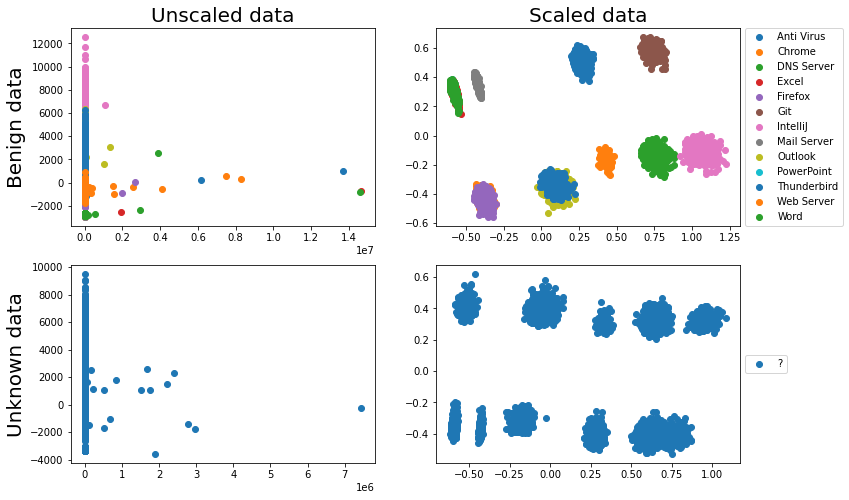

In [16]:
# Plots unscaled and scaled features
assignment.plot_scaled()

**Question 2.2.** Look at the above plots, the left plots show the unscaled features and the right plots show the scaled features. As we can see, the scaled features are separated better then the unscaled features. However, are all applications seperated properly? If you see some overlap, is this something you could explain or do you need to choose different features?

**NB:** Note that some overlap might be caused by the dimentionality reduction from the PCA in the plotting method. However, this will very likely result in clusters being very close together, but will likely not result in a *complete* overlap.

In [ ]:
## the application that overlap share very similar values for the features extracted

## 3. Model/Parameter selection
Currently we have a scaled matrix where each row contains a data sample, and each column a feature. Now that we have prepared the features that we feed into our NIDS, we have to choose an anomaly detection algorithm to observe new behaviour. Given that we only have access to benign data and unknown data, we cannot train a classifier. Therefore, we need to train a novelty/outlier detection algorithm. In this assignment we will use a One-Class SVM.

As you have learned during the lecture, a One-Class SVM uses a kernel function K to define the geometric relationship between a feature vector X and the support vectors Y. For an RBF (Gaussian) kernel, this relationship is defined as:

$$K(X, Y) = e^{-\frac{||x - y||^2}{2\sigma^2}}$$

**Question 3.1.** Implement the RBF kernel function.

In [17]:
def K(X, Y, sigma=1):
    k = np.exp(np.divide(-np.linalg.norm(X-Y)**2,2*((sigma)**2))) 
    return k

A support vector machine (SVM) uses its kernel function to compute a score between a feature vector $X$ and support vector $Y$. You can think of the score as the likelihood **(note that it is not a probability)** that $X$ and $Y$ originate from the same underlying distribution. Because an SVM contains multiple support vectors $Y_i$, we can assign a score to feature vector $X$ based on the likelihood that it shares the same underlying distribution with any of our support vectors $Y_i \in Y$. We compute this overall score by simply adding the (weighted) scores for $X$ with each support vector $Y_i$, which is called the soft score:

$$\text{soft score} = \sum_{i=0}^N w_iK(X, Y_i) \leq \tau$$

We compare this soft score with a threshold $\tau$ to determine if a point falls within or outside of our model. The assignment automatically computes the soft score with all weights as 1 for all given points $X$, support vectors $Y$ and your implemented kernel $K$.

We show the influence of different kernel values on the decision function for random support vectors and datapoints. All datapoints that appear in the red area are considered to fall within the soft hypersphere. All datapoints outside the area are considered anomalous. We see that the sigma changes the shape of the hypershpere and the threshold changes the volume while preserving the shape.

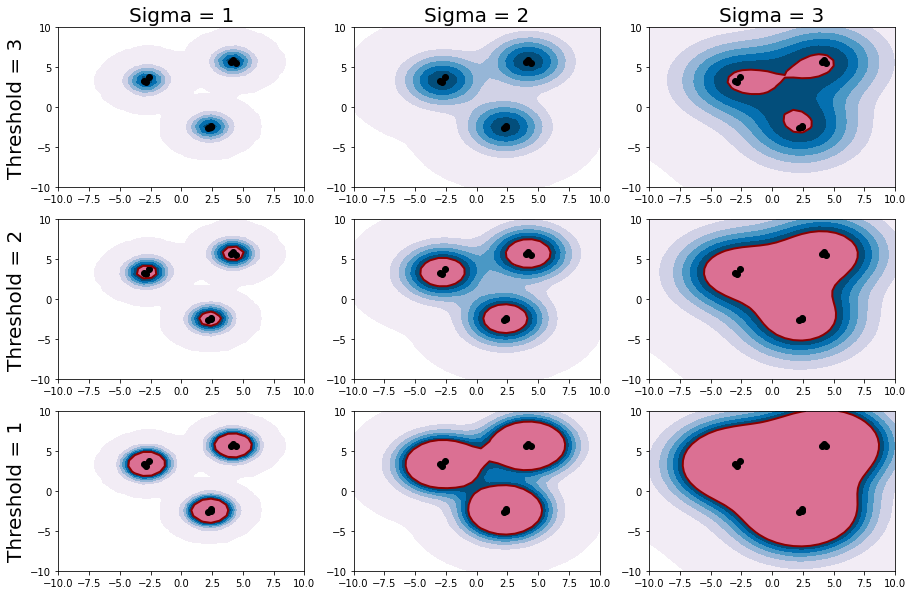

In [18]:
# Plots random kernels and shows the spheres produced by your kernel
assignment.plot_kernels(K, sigmas=[1, 2, 3], thresholds=[3, 2, 1])

Later in this assignment, we will use the `OneClassSVM` implementation from the `scikit-learn` library. This implementation automatically choses optimal values for the weights $w_i$ and threshold $\tau$. However, we can still set two values to influence this decision: `gamma` and `nu`. The `gamma` value determines the size of the kernel, similar to the value of $\sigma$. Additionally, the `nu` value sets an upper bound on the fraction of training errors and a lower bound of the fraction of support vectors. We recall from the lecture that we want to minimize the threshold $\tau$. The `nu` value allows us to adjust the number of support vectors as well as set the allowed number of errors the OneClassSVM can make during training while keeping the $\tau$ value minimal.

## 4. Evaluation

Now that we have taken a closer look at One-Class SVMs, we have to think about how we can train, test and evaluate the model. We do this to get an idea of how well the NIDS will perform in a real-world scenario, which allows us to optimise its parameters before deployment and classification of the unknown data. In order to evaluate our model, we require labelled data, i.e. data from the `benign.csv` file. Given that all data is benign, it might seem difficult to assess whether there are malicious network connections. However, we can think of ways to redefine our problem such that we can only use benign data in order to train and test the NIDS.

All data in the `benign.csv` file is labelled with the corresponding application that produced the data. We know that a malicious program is just another application that we have not seen in our benign data. We will leverage this observation to train and test our model.

To this end, we randomly select a couple of applications that we leave out of the training data and only use for the test dataset. These applications simulate the 'unknown' apps or malware that we might encounter in the `unknown.csv` dataset. All other applications will be present in both the train and test set. However, for these applications, we still need to select a portion of the data that we use in the test set, and a portion of the data that we use in the train set. We can define this portion with a `ratio`.

As an example, consider a dataset of 5 applications: $Apps = [\text{Firefox}, \text{Word}, \text{Git}, \text{Excel}, \text{Outlook}]$. Now we randomly select $[\text{Firefox}, \text{Excel}]$ to be our apps for the testing set, meaning $[\text{Word}, \text{Git}, \text{Outlook}]$ are the apps present in both the train and test datasets. Next we define our `ratio` for training items as `0.75`. This means that we select 75% of the flows from $[\text{Word}, \text{Git}, \text{Outlook}]$ as our train data and add the remaining 25% of flows to the test dataset.

_Hint: we round the ratio if it does not split properly_

Therefore, if we have the following input:

**Apps train:** $[\text{Word}, \text{Git}, \text{Outlook}]$ <br>
**Apps test:** $[\text{Firefox}, \text{Excel}]$ <br>
**Ratio:** 0.75 <br>

We will get the following split:

<div style="-webkit-column-count: 3; -moz-column-count: 3; column-count: 3; -webkit-column-rule: 1px dotted #e0e0e0; -moz-column-rule: 1px dotted #e0e0e0; column-rule: 1px dotted #e0e0e0; text-align: center;">
    <div style="display: inline-block;">
<h3 style="text-align: center;">&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Original data and Labels</h3>
        
|  Label  | feature 1 | feature 2 | ... | feature n |
|:-------:|:---------:|:---------:|:---:|:---------:|
| Firefox | value     | value     | ... | value     |
| Firefox | value     | value     | ... | value     |
| Word    | value     | value     | ... | value     |
| Word    | value     | value     | ... | value     |
| Word    | value     | value     | ... | value     |
| Git     | value     | value     | ... | value     |
| Git     | value     | value     | ... | value     |
| Excel   | value     | value     | ... | value     |
| Excel   | value     | value     | ... | value     |
| Excel   | value     | value     | ... | value     |
| Excel   | value     | value     | ... | value     |
| Outlook | value     | value     | ... | value     |
| Outlook | value     | value     | ... | value     |
| Outlook | value     | value     | ... | value     |
| Outlook | value     | value     | ... | value     |
         
</div>
<div style="display: inline-block;">
<h3 style="text-align: center;">&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Train set</h3>
        
|  Label  | feature 1 | feature 2 | ... | feature n |
|:-------:|:---------:|:---------:|:---:|:---------:|
| Word    | value     | value     | ... | value     |
| Word    | value     | value     | ... | value     |
| Git     | value     | value     | ... | value     |
| Outlook | value     | value     | ... | value     |
| Outlook | value     | value     | ... | value     |
| Outlook | value     | value     | ... | value     |
        
</div>
<div style="display: inline-block;">
<h3 style="text-align: center;">&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Test set</h3>

|  Label  | feature 1 | feature 2 | ... | feature n |
|:-------:|:---------:|:---------:|:---:|:---------:|
| Firefox | value     | value     | ... | value     |
| Firefox | value     | value     | ... | value     |
| Word    | value     | value     | ... | value     |
| Git     | value     | value     | ... | value     |
| Excel   | value     | value     | ... | value     |
| Excel   | value     | value     | ... | value     |
| Excel   | value     | value     | ... | value     |
| Excel   | value     | value     | ... | value     |
| Outlook | value     | value     | ... | value     |
        
</div>
</div>

**Question 4.1.** Implement the function `split()` that implements the split technique described above.

In [19]:
def split(data, labels, apps_train, apps_test, ratio):
    training_data = []
    training_label = []
    testing_data = []
    testing_label = []
    comp_train_data = []
    comp_train_label = []
    
    #create training data
    for i in range(len(labels)):
        if(labels[i] in apps_train):
            training_data.append(data[i])
            training_label.append(labels[i])
    
    #create testing data
    for i in range(len(labels)):
        if(labels[i] in apps_test):
            testing_data.append(data[i])
            testing_label.append(labels[i])
    
    #split training data
    index = int(round(ratio*len(training_data)))
    comp_train_data = training_data[:index]
    comp_train_label =  training_label[:index] 
    testing_data.extend(training_data[index:])
    testing_label.extend(training_label[index:])

    
    return comp_train_data,comp_train_label, testing_data, testing_label
    
# Sets split method
assignment.split = split

You can use the code below to test your implementation of `split()` for several test cases, set variable `verbose = True` to print each test case.

In [20]:
# Tests split method
assignment.test_split(verbose=False)

All test cases passed.


The following code uses your `split()` method to obtain the train and test split for the data in `benign.csv`.

**Important**: Note that the labels for this split are integers that are `+1` if the corresponding application is in the training data or `-1` if the corresponding application is not in the training data. We will use this to determine whether our NIDS can correctly determine whether apps are present in the training set (`+1`, benign) or whether they are not present in the training set (`-1`, malicious).

In [21]:
# Gets training and testing data
X_train, y_train, X_test, y_test = assignment.get_split(
    
        # Select the apps used for training, the rest will be used for testing
        apps_train = [
            'IntelliJ',
            'PowerPoint',
            'Thunderbird',
            'Web Server',
            'Chrome',
            'Word',
            'Mail Server',
            'Anti Virus',
            'Outlook',
            'DNS Server',
        ],
    
    
        # Select the ratio of flows from training apps used for training
        ratio     = 0.75,
)

# Prints overview of data
print(
"""
Your data is structured as follows:
-----------------------------------
Train data   (X_train): np.array of shape={}
Train labels (y_train): np.array of shape={}
Test  data   (X_test ): np.array of shape={}
Test  labels (y_test ): np.array of shape={}
""".format(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
)


Your data is structured as follows:
-----------------------------------
Train data   (X_train): np.array of shape=(7198, 8)
Train labels (y_train): np.array of shape=(7198,)
Test  data   (X_test ): np.array of shape=(5391, 8)
Test  labels (y_test ): np.array of shape=(5391,)



Now that we have split our data into training and testing sets with the corresponding labels, we want to compute some metrics over a prediction. We recall from the lecture that most metrics are based on the True Positive (TP), False Positive (FP), True Negative (TN) and False Negative values (FN).

 * True Positives (TP), the amount of samples predicted as *unknown* (-1), that should be labelled as *unknown* (-1).
 * True Negatives (TN), the amount of samples predicted as *known* (+1), that should be labelled as *known* (+1).
 * False Positives (FP), the amount of samples predicted as *unknown* (-1), that should be labelled as *known* (+1).
 * False Negatives (FN), the amount of samples predicted as *known* (+1), that should be labelled as *unknown* (-1).
 
Or in a diagram:

| $ $                | Actual Unknown      | Actual Known        |
|--------------------|---------------------|---------------------|
| Predicted Unknown  | True Positive (TP)  | False Positive (FP) |
| Predicted Known    | False Negative (FN) | True Negative (TN)  |

**Question 4.2.** Given these definitions of TP, TN, FP, FN, implement the methods that compute each value given the predictions (`y_pred`) and actual labels (`y_true`).

In [22]:
def TP(y_true, y_pred):
    count  = 0
    for i in range(len(y_true)):
        if(y_pred[i] == -1 and y_pred[i] == y_true[i]):
            count += 1  
    return count
    
def TN(y_true, y_pred):
    count  = 0
    for i in range(len(y_true)):
        if(y_pred[i] == 1 and y_pred[i] == y_true[i]):
            count += 1  
    return count
    
    
def FP(y_true, y_pred):
    count  = 0
    for i in range(len(y_true)):
        if(y_pred[i] == -1 and y_true[i] == 1):
            count += 1  
    return count
    
def FN(y_true, y_pred):
    count  = 0
    for i in range(len(y_true)):
        if(y_pred[i] == +1 and y_true[i] == -1):
            count += 1  
    return count
    
    
# Sets True/False Positive/Negative methods
assignment.TP = TP
assignment.TN = TN
assignment.FP = FP
assignment.FN = FN

You can use the code below to test your implementations for the True/False Positive/Negative values for several test cases, set variable `verbose = True` to print each test case.

In [23]:
# Tests your implementation of True/False Positive/Negative values
assignment.test_metrics(verbose=False)

All test cases passed.


We use your implementation provided above to compute several performance metrics. There are various metrics that are used widely in the evaluation of machine learning techniques. We recall 5 of these from the lecture:

The True Positive Rate (TPR), also called sensitivity, measures the proportion of actual positives that are correctly identified as such.
$$\text{TPR} = \frac{\text{TP}}{\text{TP}+\text{FN}} = 1-\text{FNR}$$

The True Negative Rate (TNR), also called specificity, measures the proportion of actual negatives that are correctly identified as such.
$$\text{TNR} = \frac{\text{TN}}{\text{TN}+\text{FP}} = 1-\text{FPR}$$

The False Positive Rate (FPR), measures the proportion of actual negatives that are identified as positives. If a NIDS has a high FPR, it will not find malicious software, making it useless.
$$\text{FPR} = \frac{\text{FP}}{\text{TN}+\text{FP}} = 1-\text{TNR}$$

The False Negative Rate (FNR), measures the proportion of actual positives that are identified as negatives. If a NIDS has a high FNR, it will raise alarms for benign network traffic, causing a lot of frustration for the people on the network.
$$\text{FNR} = \frac{\text{FN}}{\text{TP}+\text{FN}} = 1-\text{TPR}$$

The Accuracy (ACC) combines the TPR and FPR to get a complete overview of the system performance. An accuracy of 1.0 means everything is correctly classified. An accuracy of 0.0 means nothing is correctly classified.
$$\text{ACC} = \frac{\text{TP}+\text{TN}}{\text{TP}+\text{TN}+\text{FP}+\text{FN}}$$

Additionally, you will also often encounter the [Precision, recall](https://en.wikipedia.org/wiki/Precision_and_recall) and [F1-score](https://en.wikipedia.org/wiki/F-score). The precision gives the ratio of 'how many selected items are relevant' and the recall gives the ratio of 'how many relevant items are selected'. The F1-score gives the harmonic mean between precision and recall and is often used in place of the accuracy. For reference, the formulas for all three metrics are given below.

$$\text{Precision} = \frac{\text{TP}}{\text{TP}+\text{FP}}$$

$$\text{Recall} = \text{TPR} = \frac{\text{TP}}{\text{TP}+\text{FN}}$$

$$\text{F1-score} = 2 \cdot \frac{\text{Precision} \cdot \text{Recall}}{\text{Precision} + \text{Recall}} = \frac{2 \text{TP}}{2 \text{TP} + \text{FP} + \text{FN}}$$

We compute these metrics based on your True Positive, True Negative, False Positive, and False Negative implementations.

## 5. Classifier
Now that we have prepared the data and implemented some of the evaluation metrics, we are ready to create our Network Intrusion Detection System (NIDS). To this end, we will use the [OneClassSVM](https://scikit-learn.org/stable/modules/generated/sklearn.svm.OneClassSVM.html) implementation from the scikit-learn library. This model uses the `fit()` method with train data of known classes to learn its model. Subsequently it will use the method `predict()` with test data as +1 if they fit the known model, or -1 if they are considered anomalous.

**Question 5.1.** We import the One-class SVM from [Scikit-Learn - OneClassSVM](https://scikit-learn.org/stable/modules/generated/sklearn.svm.OneClassSVM.html). Given this class, initialize it with different parameters and run the subsequent code to fit and predict our training and testing data. Try to get the best performance by adjusting the `kernel`, `gamma` and `nu` values.

**NB**: The OneClassSVM implementation of scikit-learn uses the `gamma` parameter for the RBF kernel, which in this library is defined as $\gamma = \frac{1}{2\sigma^2}$. This changes the kernel function from
$K(X, Y) = e^{-\frac{||x - y||^2}{2\sigma^2}}$ to $K(X, Y) = e^{-\gamma||x - y||^2}$.

_Hint 1: You may notice the performance is not that good. If that is the case, go back to the `assignment.get_split()` method and change the parameters with different values for `ratio` and `apps_train`._

_Hint 2: From your answer at question 2.2, you should be able to explain why some combinations of training versus test app combinations give bad results._

In [92]:
from sklearn.svm import OneClassSVM

assignment.NIDS = OneClassSVM(
    kernel =   'rbf',
    gamma  =   3,
    nu     =   0.001,
)



# This code fits the NIDS using the training data X_train
assignment.NIDS.fit(X_train)
# This code lets the NIDS predict the test data X_test
y_pred = assignment.NIDS.predict(X_test)

# We evaluate the prediction y_pred and compare it with the actual values y_test
assignment.prediction_report(y_test, y_pred)


Prediction report
-----------------
True  Positive Rate (TPR) = 0.077540
True  Negative Rate (TNR) = 0.936223
False Positive Rate (FPR) = 0.063777
False Negative Rate (FNR) = 0.922460
Accuracy            (ACC) = 0.459655

Precision                 = 0.602597
Recall                    = 0.077540
F1-score                  = 0.137400



## 6. Submission
If you played around with different combinations of training and testing data and selected good parameter values for your OneClassSVM, you can submit your assignment which will be evaluated on the `data/unknown.csv` data. Please fill out your `student_number` and `highscore_name`. To pass you will need to achieve an Accuracy $\geq$ 0.9 and a False Positive Rate of $\leq$ 0.05. 

_Hint: If you cannot seem to get a good performance, perhaps the features that you have chosen for your NIDS in the `extract()` method need to be improved, or the model parameters that you have chosen for the `OneClassSVM` are not suitable for the NIDS_

**Important notices:**
 1. The `submit` function evaluates the performance of your NIDS on the `data/unknown.csv` data. Note that this dataset is different from the data you tested with in question 5.1. Therefore, the performance of your NIDS may differ. If you are unable to achieve a good performance, you may have overfitted your NIDS on the training data.
 2. We store your submissions on our server and these values will be used to check if you passed the assignment or not. Therefore, make sure that you submit your prediction correctly using the `assignment.submit()` method. If any error occurs, the error message will be printed. If you are unable to fix these error messages, please contact the TA at [t.s.vanede@utwente.nl](mailto:t.s.vanede@utwente.nl).
 3. The `assignment.submit()` method requires internet access.
 4. This assignment is graded individually. Please use your actual student number, e.g. `s1234567` and only your own student number. We log each sign of misconduct.
 5. If you want to participate in the highscores, please provide a `highscore_name`. If you **do not** want to participate in the highscores please set this field to `None`. You can check the highscores at [vm-thijs.ewi.utwente.nl/ml/](https://vm-thijs.ewi.utwente.nl/ml/).

In [93]:
# Fill in your credentials to submit the assignment.
assignment.submit(
    student_number = "s2261065",
    highscore_name = "Anthony",
)


Prediction report
-----------------
True  Positive Rate (TPR) = 0.351663
True  Negative Rate (TNR) = 0.997971
False Positive Rate (FPR) = 0.002029
False Negative Rate (FNR) = 0.648337
Accuracy            (ACC) = 0.901350

Precision                 = 0.968224
Recall                    = 0.351663
F1-score                  = 0.515936

You have passed the assignment!


## 7. Optimisation (optional)
If you passed the assignment, you can try to improve your performance by selecting different features and optimizing the `gamma` and `nu` values of your `OneClassSVM`. However, there are also other methods we can explore. Consider a benign application $B$ that only runs on our server with IP address `10.0.0.1`. We are able to detect this application in the network traffic using our previous NIDS. Now consider a malicious application $M$ that behaves very similar to application $B$, so much, that our NIDS would be unable to distinguish application $B$ from application $M$. As we have seen in question 2.2, this is something that will occur in practice.

As a partial solution, we can try to create a more fine-grained NIDS that does not make a single model for all traffic on the network, but instead create a model **per device**. This way, if malicious application $M$ infects any of our desktop machines `10.0.0.2-4`, we would still be able to detect that there is a new application running. This solution is not full proof, because this new NIDS would still not be able to detect application $M$ on the server `10.0.0.1`. Nevertheless, it is a slight improvement on our original NIDS design.

**Question 7.1. (optional)** Create the NIDS described above by implementing the DeviceNIDS class. This class should support the `fit(self, X)` and `predict(self, X)` methods that take a scaled feature matrix `X` to fit and predict, respectively.

In [17]:
class DeviceNIDS(object):
    
    def __init__(self):
        # The code between this text should be implemented
        self.classifiers = {
            '10.0.0.1': OneClassSVM(kernel="<your_kernel>", gamma="<your_gamma>", nu="<your_nu>"),
            '10.0.0.2': OneClassSVM(kernel="<your_kernel>", gamma="<your_gamma>", nu="<your_nu>"),
            '10.0.0.3': OneClassSVM(kernel="<your_kernel>", gamma="<your_gamma>", nu="<your_nu>"),
            '10.0.0.4': OneClassSVM(kernel="<your_kernel>", gamma="<your_gamma>", nu="<your_nu>"),
        }
        # The code between this text should be implemented
    
    def fit(self, X):
        # The code between this text should be implemented
        pass
        # The code between this text should be implemented
    
    def predict(self, X):
        # The code between this text should be implemented
        pass
        # The code between this text should be implemented
        
    
    
# Set the NIDS to the newly implemented DeviceNIDS
assignment.NIDS = DeviceNIDS()

# Fill in your credentials to submit the assignment.
assignment.submit(
    student_number = "<your_student_number>",
    highscore_name = "<your_highscore_name>",
)

c:\python38\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


TypeError: int() argument must be a string, a bytes-like object or a number, not 'NoneType'